# Notebook - Análise da evasão

Dados do Instituto de Ciências Exatas (IE).

### Importando bibliotecas:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv

import utils
import process
import pre_process

%matplotlib inline

In [2]:
# Reload module

import importlib
importlib.reload(process)

<module 'process' from '/home/raphaela/Documentos/unb/pibic/trj-academica/pipeline/process.py'>

 ### Leitura dos dados

In [3]:
# SIGRA_BEFORE_2004 = '../data/new/sigra_ate_2004.csv'
# SIGRA = '../data/new/sigra_a_partir_de_2005.csv'
SIGAA     = '../data/new/sigaa.csv'

# data_sigra_before_2004 = pd.read_csv(SIGRA_BEFORE_2004, sep=';', low_memory=False)
# data_sigra = pd.read_csv(SIGRA, sep=';', low_memory=False)
data_sigaa = pd.read_csv(SIGAA, sep=';', low_memory=False)

# data_sigra_before_2004 = pre_process.map_columns(data_sigra_before_2004)
# data_sigra = pre_process.map_columns(data_sigra)
data_sigaa = pre_process.map_columns(data_sigaa)

data_pre = pd.concat([data_sigaa])

In [4]:
# OLD = '../data/old/ie_data.csv'
# data_pre = pd.read_csv(OLD, sep=';', low_memory=False)
# data_pre.shape

## Pré-Processamento

Processo de limpeza dos dados. Aqui, é feita a remoção de ruídos e o tratamento de atributos que possuem dados ausentes.
São removidos os alunos que: 
- Eram ativos que faleceram
- Tinham o atributo "Tipo de escola" como "Não informado"
- Possuíam o CEP incorreto, mal formatado e/ou com o CEP da própria UnB;
- São de outras universidades.

Além disso, são removidos, também:
- Disciplinas não obrigatórias;
- O atributo nome da disciplina;
- Atributo período de saída.

In [5]:
attrs = []
attrs_cat = []
data_pre = pre_process.format_data(data_pre)

data_pre = pre_process.dataframe_specific_adjustments(data_pre)
data_pre = pre_process.erase_attr(data_pre)
data_pre = pre_process.remove_nan(data_pre)

year_range = [2004, 2019]
data_pre = pre_process.time_frame(data_pre, year_range)

horizon = 1  # 1 year = 2 semesters
data_pre = pre_process.beyond_horizon(data_pre, horizon)

data_pre = pre_process.dropout(data_pre, attrs)
data_pre = pre_process.dropout_before_horizon(data_pre, horizon)
data_pre = pre_process.course(data_pre, attrs)
data_pre = pre_process.public_school(data_pre, attrs)
data_pre = pre_process.gender(data_pre, attrs)
data_pre = pre_process.entry(data_pre, attrs, attrs_cat)
data_pre = pre_process.age(data_pre, attrs)
data_pre = pre_process.quota(data_pre, attrs, attrs_cat)

data_pre = pre_process.cic_courses(data_pre)
data_pre = pre_process.erase_internal_transfer_students(data_pre)

data_pre = pre_process.one_hot_encoding(data_pre, ['quota_type', 'entry'], attrs, attrs_cat)
data_pre = data_pre.dropna()
print(data_pre)

credits_dict = pre_process.subject_credits(data_pre)

              aluno  female  age        cep  quota  public_school  \
4109    aluno104017   False   19  70277-150  False          False   
4110    aluno104017   False   19  70277-150  False          False   
4111    aluno104017   False   19  70277-150  False          False   
4112    aluno104017   False   19  70277-150  False          False   
4113    aluno104017   False   19  70277-150  False          False   
...             ...     ...  ...        ...    ...            ...   
327638  aluno235876   False   19  73015-103   True          False   
327639  aluno235876   False   19  73015-103   True          False   
327640  aluno235876   False   19  73015-103   True          False   
327641  aluno235876   False   19  73015-103   True          False   
327642  aluno235876   False   19  73015-103   True          False   

                        course  periodo_ingresso_unb  periodo_ingresso_curso  \
4109                computação               20102.0                 20102.0   
4110       

Divide dataframe by course:

In [6]:
data_course, attrs_course, attrs_cat_course = pre_process.divide_course(
    data_pre, attrs, attrs_cat
)
for i in data_course:
    print(i)
for i in attrs_course:
    print(i)
for i in attrs_cat_course:
    print(i)

data_course['all'] = data_pre.copy()
attrs_course['all'] = attrs.copy()
attrs_cat_course['all'] = attrs_cat.copy()
attrs_cat_course['all'].append('course')

computação
engenharia_mecatrônica
engenharia_de_computação
ciência_da_computação
computação
engenharia_mecatrônica
engenharia_de_computação
ciência_da_computação
computação
engenharia_mecatrônica
engenharia_de_computação
ciência_da_computação


### Process Subjects and CEP

The Subjects are processed for each course individually, and Cep needs to be processed before all other attributes and drop_duplicates, otherwise it takes too long to process.

In [7]:
keys = data_course.keys()
for course in keys:
    print(course)
    data = data_course[course].copy()
    attrs = attrs_course[course]

    # Process subjects
    data = pre_process.add_semester_prefix(data)
    data = pre_process.subjects(data, attrs, horizon, credits_dict)

    data = pre_process.remove_anomalies(data)

    # Process CEP, it needs to be processed before drop_duplicates, or it takes too long to process.
    # data = data[attrs+['cep', 'aluno']].drop_duplicates()
    # data = pre_process.cep(data, attrs)

    data_course[course] = data.copy()

computação
engenharia_mecatrônica
engenharia_de_computação
ciência_da_computação
all


In [8]:
data_process = data_course.copy()

## Analysis

Cotas:

In [9]:
for course in data_course.keys():
    print(f'{course} = {data_course[course].shape}')
    print(f'quota \n{data_course[course]["quota"].value_counts()}')
    print('\n')

computação = (50, 60)
quota 
False    42
True      8
Name: quota, dtype: int64


engenharia_mecatrônica = (132, 60)
quota 
False    94
True     38
Name: quota, dtype: int64


engenharia_de_computação = (140, 61)
quota 
False    108
True      32
Name: quota, dtype: int64


ciência_da_computação = (116, 61)
quota 
False    76
True     40
Name: quota, dtype: int64


all = (438, 61)
quota 
False    320
True     118
Name: quota, dtype: int64




Desbalanceamento da base:

In [10]:

for course in data_course.keys():
    print(f'{course}:')
    freq = data_course[course]['dropout'].value_counts()
    print(freq)
    print('\n')

computação:
False    34
True     16
Name: dropout, dtype: int64


engenharia_mecatrônica:
False    112
True      20
Name: dropout, dtype: int64


engenharia_de_computação:
False    132
True       8
Name: dropout, dtype: int64


ciência_da_computação:
False    100
True      16
Name: dropout, dtype: int64


all:
False    378
True      60
Name: dropout, dtype: int64




In [12]:
data_course['all'].columns

Index(['age', 'aluno', 'cep', 'course', 'dropout', 'entry_outro',
       'entry_programa_de_avaliação_seriada',
       'entry_sisu-sistema_de_seleção_unificada', 'entry_vestibular', 'female',
       'periodo_ingresso_curso', 'periodo_ingresso_unb', 'periodo_saida_curso',
       'public_school', 'quota', 'quota_type_candidato_negro',
       'quota_type_egresso_de_escola_pública',
       'quota_type_egresso_de_escola_pública,_renda_familiar_bruta_per_capita_igual_ou_inferior_a_1,5_salários_mínimo,_auto-declarado_preto,_pardo_ou_indígena.',
       'quota_type_egresso_de_escola_pública,_renda_familiar_bruta_per_capita_igual_ou_inferior_a_1,5_salários_mínimo.',
       'quota_type_publico_alta_renda', 'quota_type_universal',
       '1_algoritmos_e_programacao_de_computadores', '1_calculo_1',
       '1_fisica_1', '1_fisica_1_experimental',
       '1_fundamentos_teoricos_da_computacao', '1_informatica_e_sociedade',
       '1_ingles_instrumental_1', '1_introducao_a_algebra_linear',
       '1_in

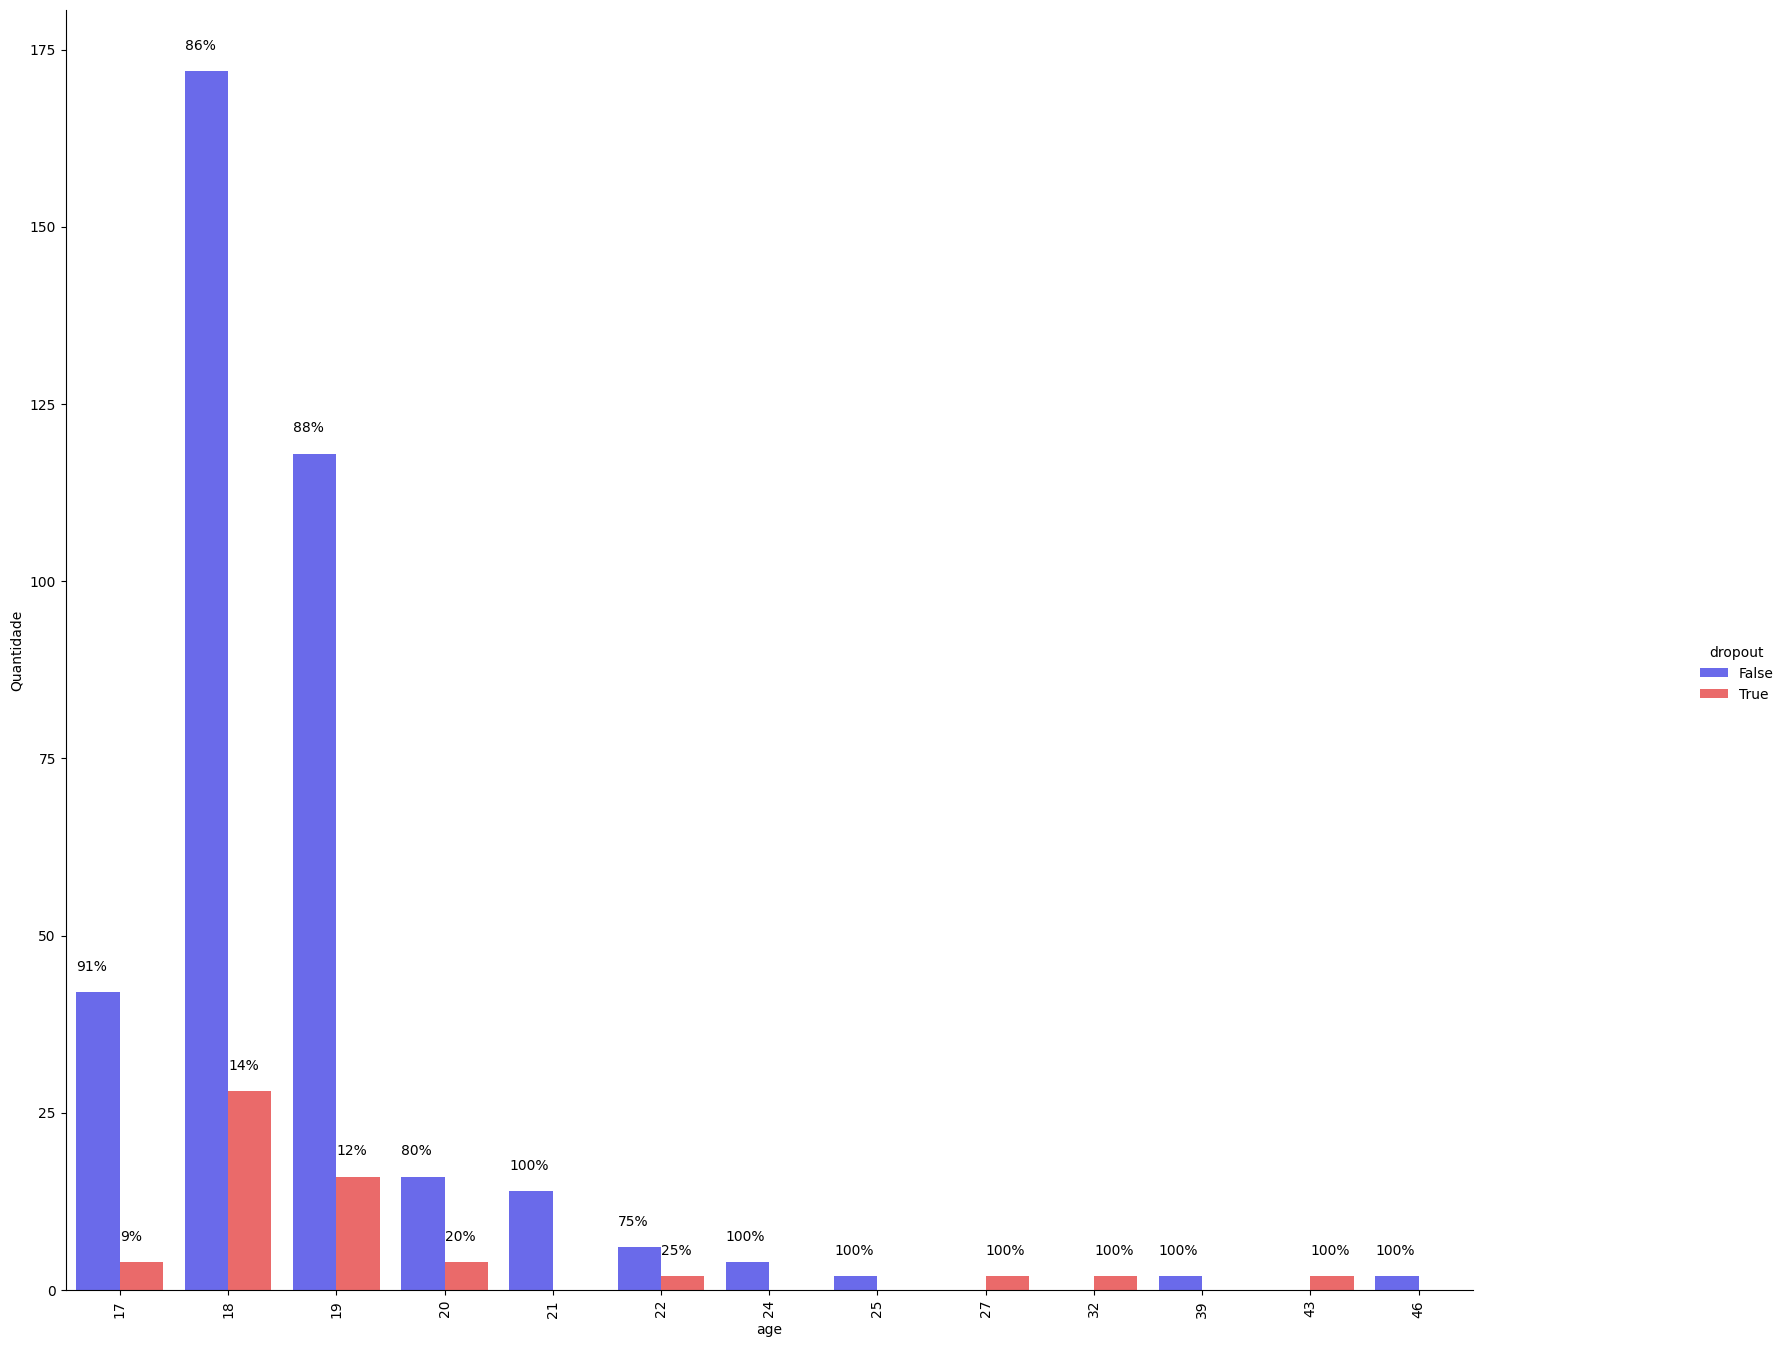

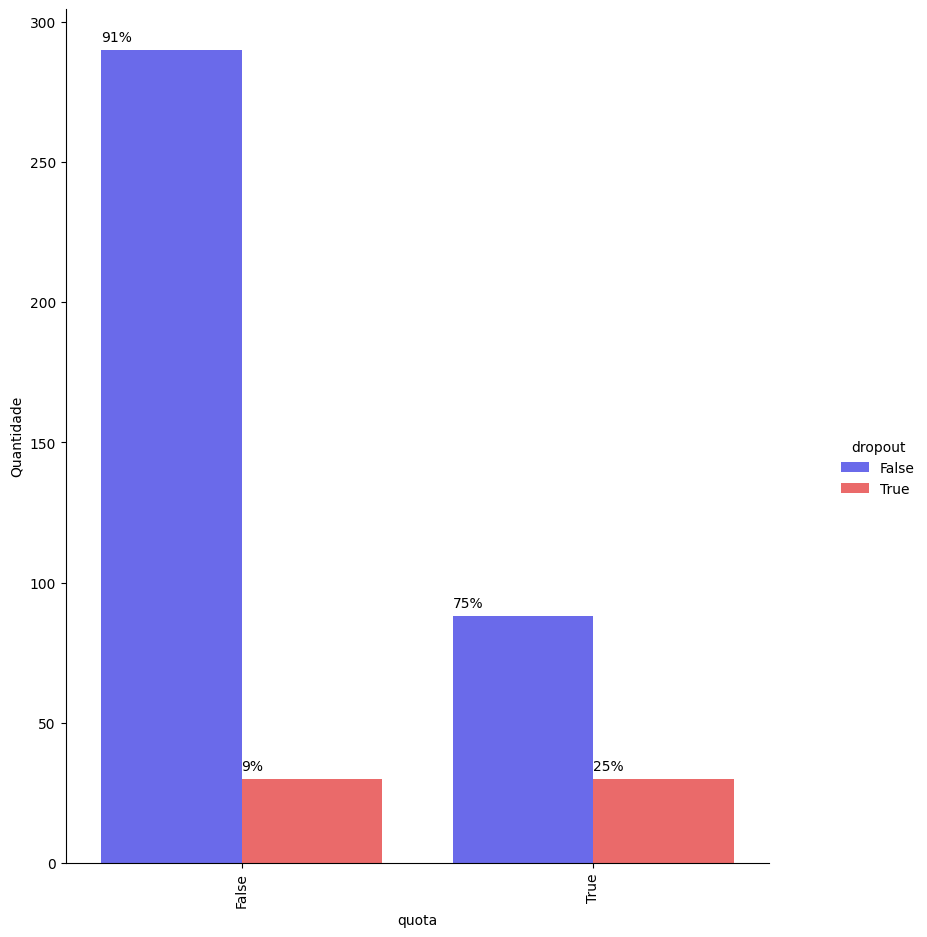

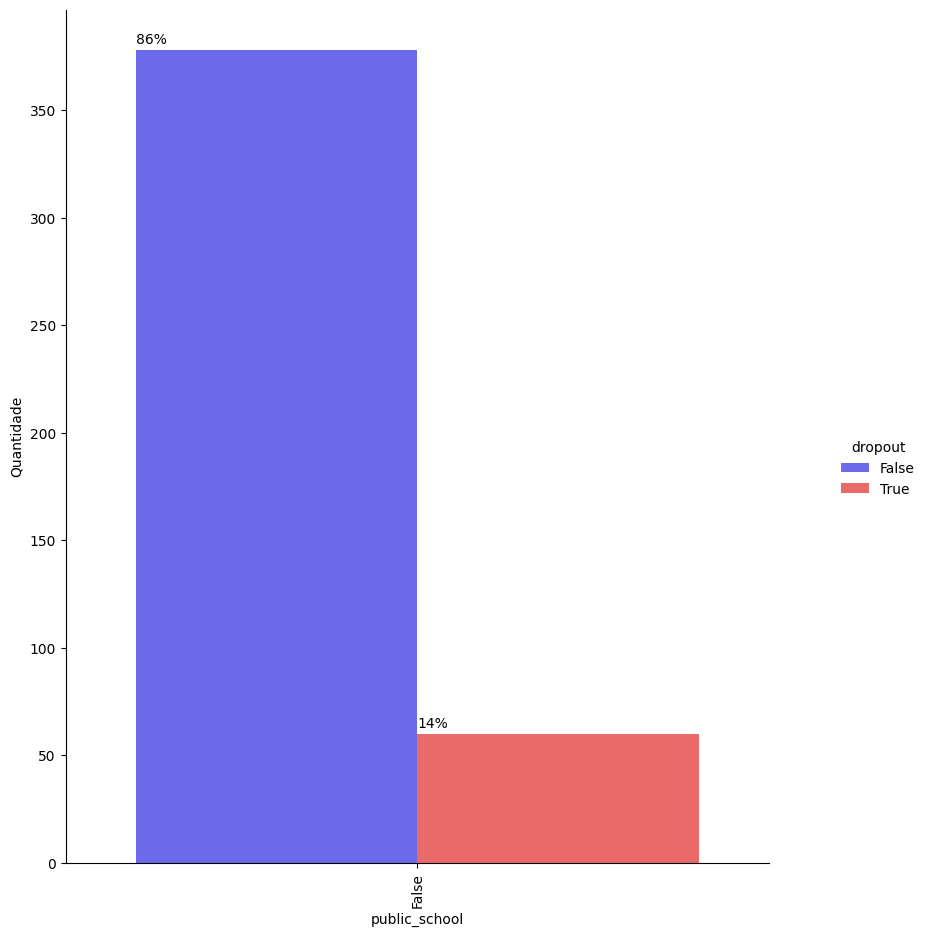

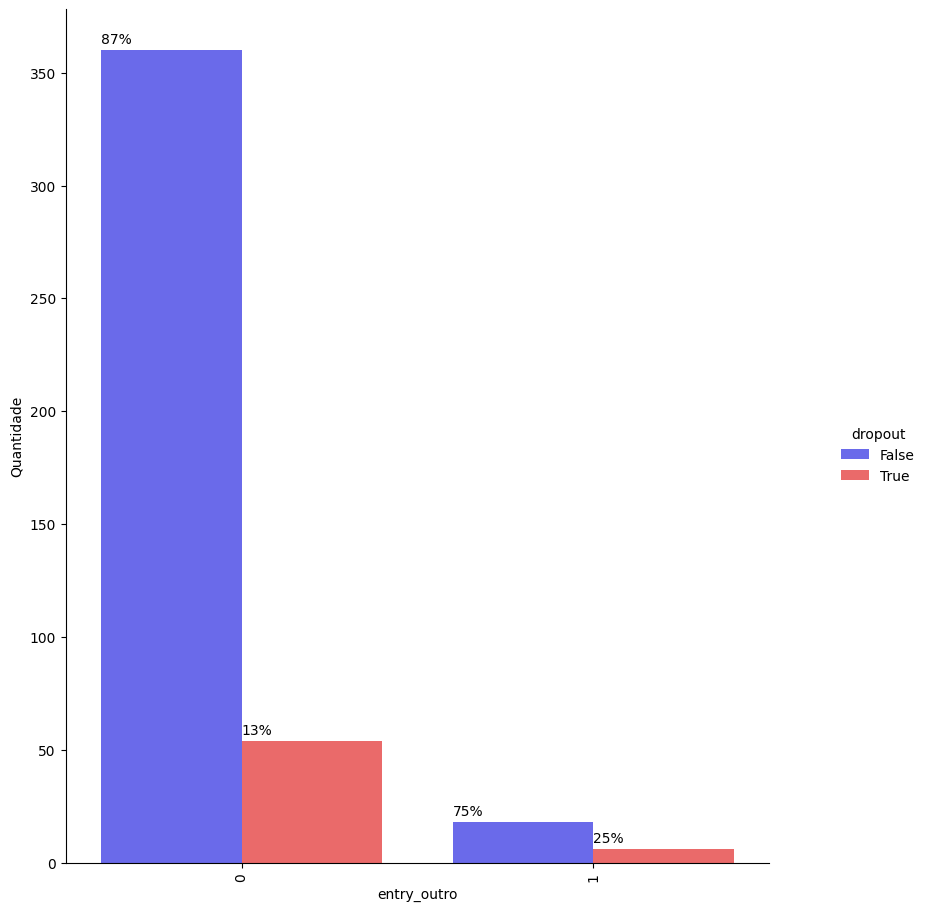

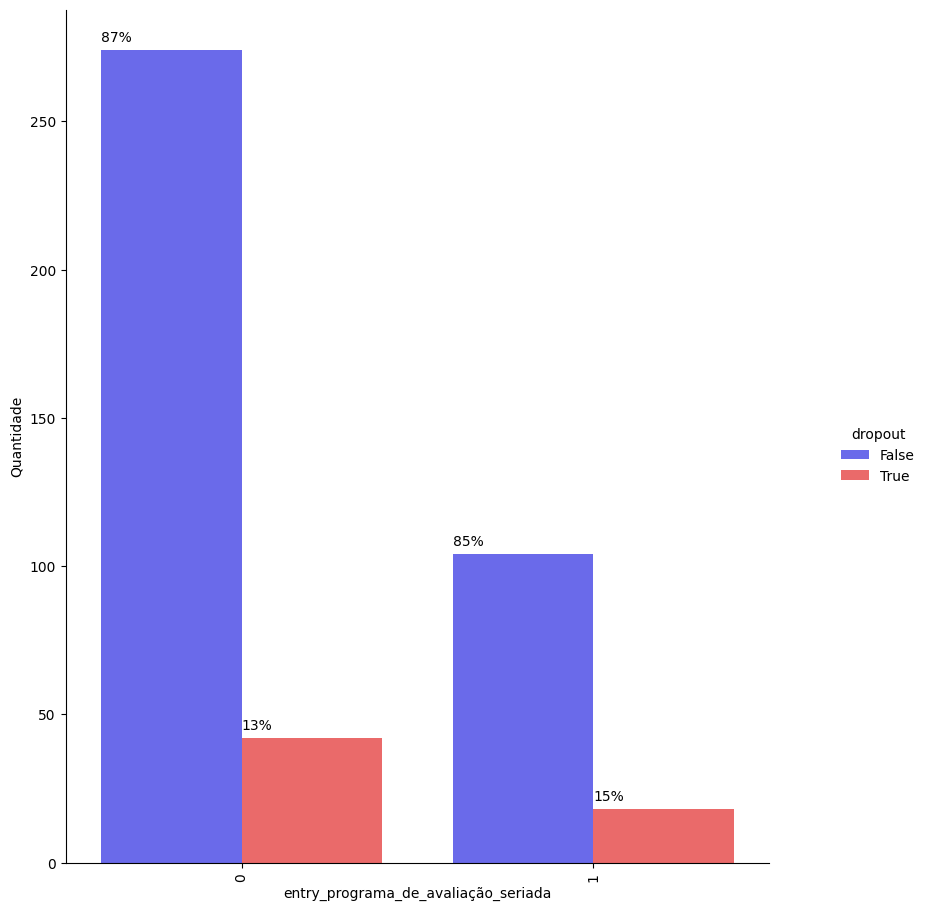

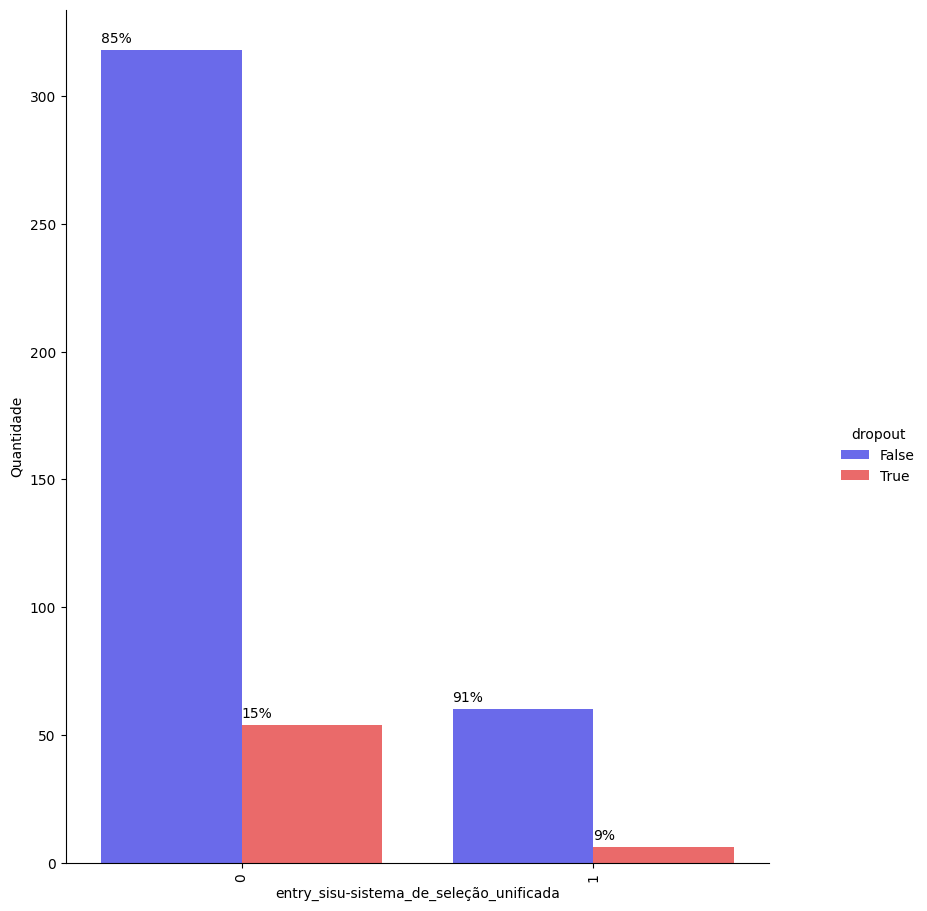

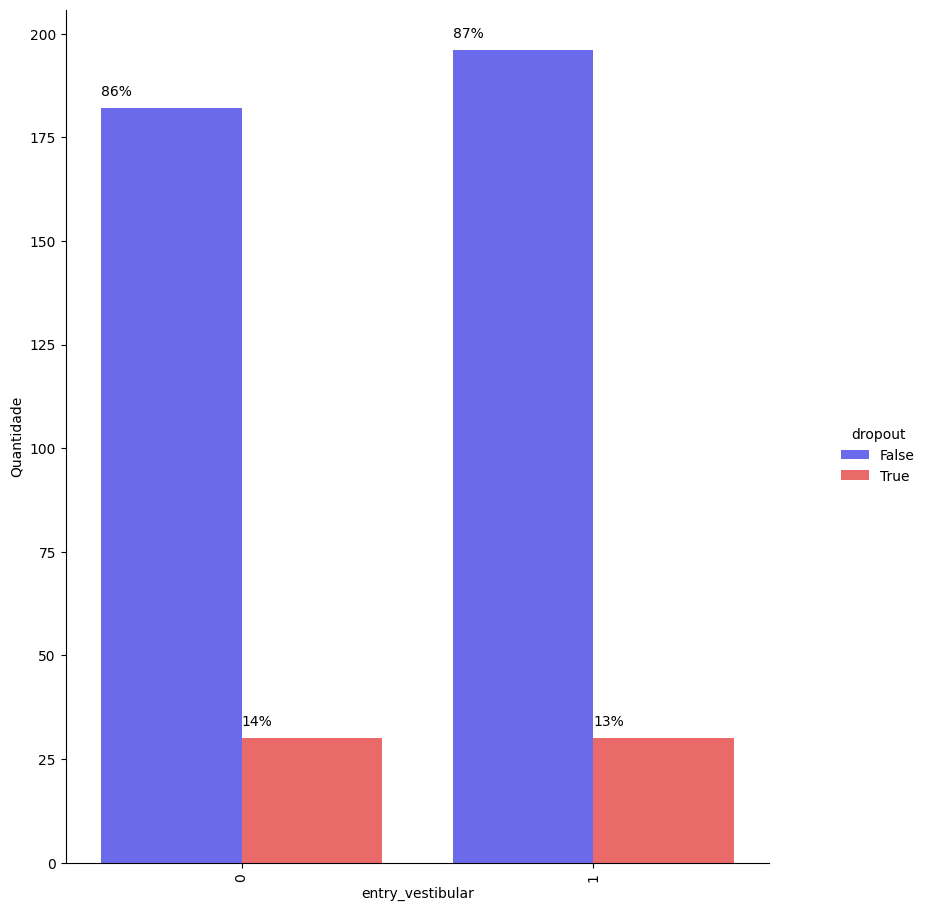

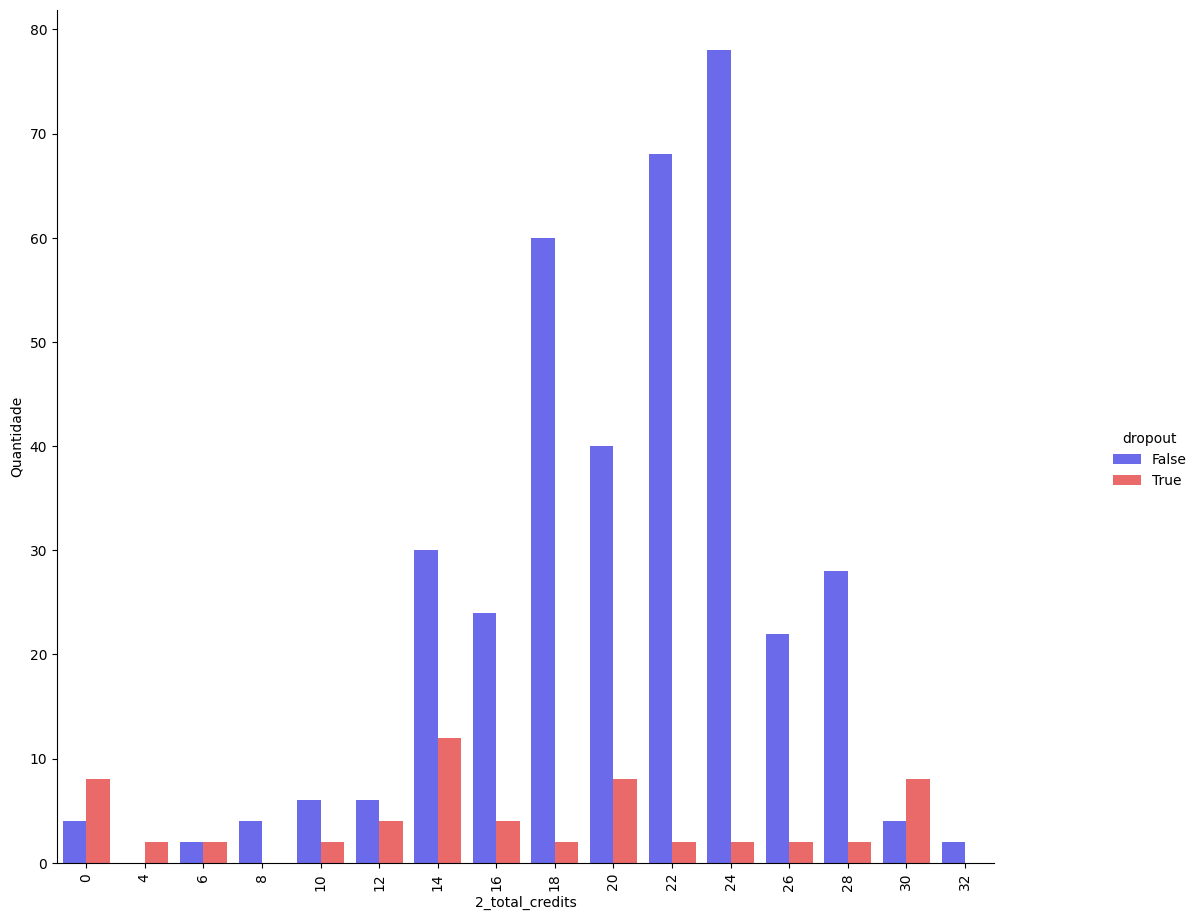

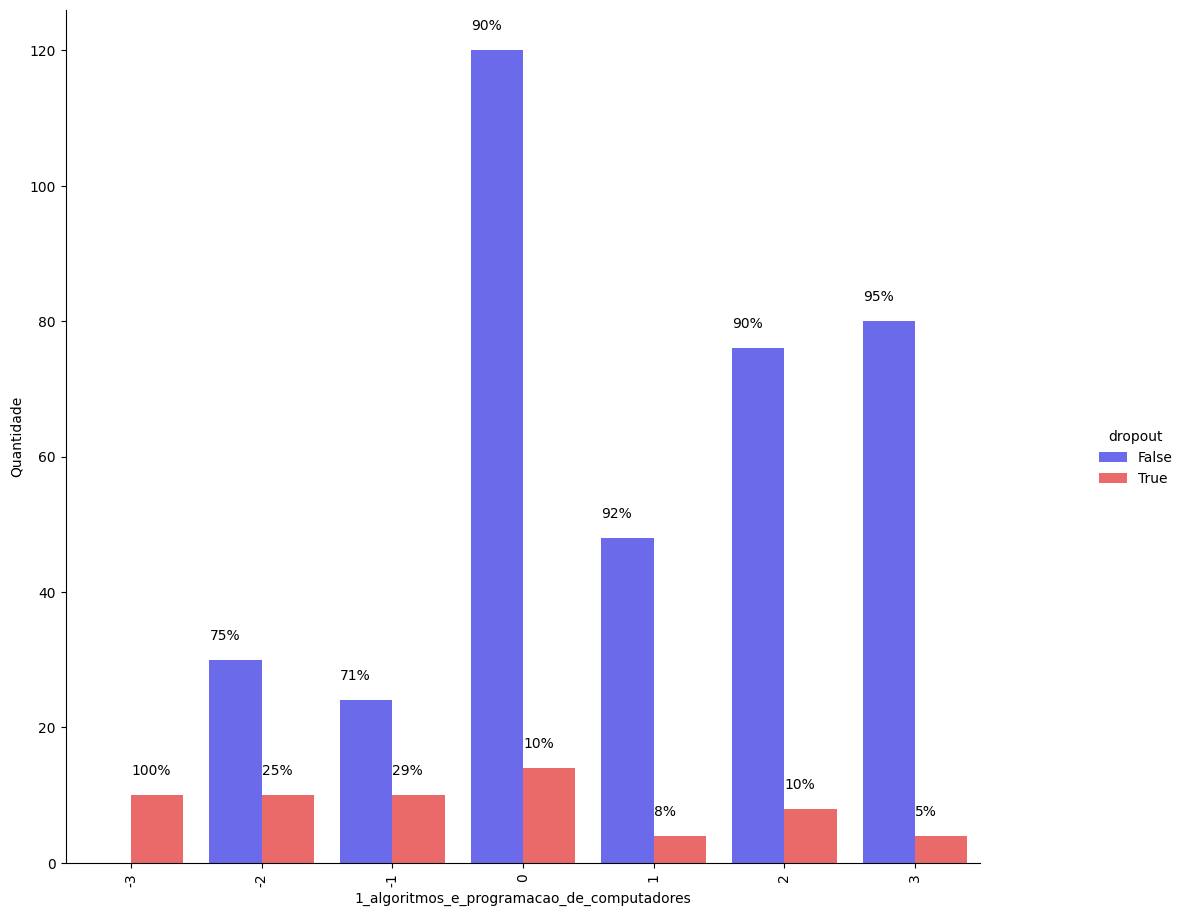

In [13]:
import importlib
importlib.reload(utils)
utils.double_bar_graph(data_course['all'], 'age', 'dropout', size=(15, 20))
utils.double_bar_graph(data_course['all'], 'quota', 'dropout')
utils.double_bar_graph(data_course['all'], 'public_school', 'dropout')
utils.double_bar_graph(data_course['all'], 'entry_outro', 'dropout')
utils.double_bar_graph(data_course['all'], 'entry_programa_de_avaliação_seriada', 'dropout')
utils.double_bar_graph(data_course['all'], 'entry_sisu-sistema_de_seleção_unificada', 'dropout')
utils.double_bar_graph(data_course['all'], 'entry_vestibular', 'dropout')
utils.double_bar_graph(data_course['all'], '2_total_credits', 'dropout', ratio=False, size=(10, 13))
utils.double_bar_graph(data_course['all'], '1_algoritmos_e_programacao_de_computadores', 'dropout', size=(10, 13))

In [14]:
data_course['all'].columns

Index(['age', 'aluno', 'cep', 'course', 'dropout', 'entry_outro',
       'entry_programa_de_avaliação_seriada',
       'entry_sisu-sistema_de_seleção_unificada', 'entry_vestibular', 'female',
       'periodo_ingresso_curso', 'periodo_ingresso_unb', 'periodo_saida_curso',
       'public_school', 'quota', 'quota_type_candidato_negro',
       'quota_type_egresso_de_escola_pública',
       'quota_type_egresso_de_escola_pública,_renda_familiar_bruta_per_capita_igual_ou_inferior_a_1,5_salários_mínimo,_auto-declarado_preto,_pardo_ou_indígena.',
       'quota_type_egresso_de_escola_pública,_renda_familiar_bruta_per_capita_igual_ou_inferior_a_1,5_salários_mínimo.',
       'quota_type_publico_alta_renda', 'quota_type_universal',
       '1_algoritmos_e_programacao_de_computadores', '1_calculo_1',
       '1_fisica_1', '1_fisica_1_experimental',
       '1_fundamentos_teoricos_da_computacao', '1_informatica_e_sociedade',
       '1_ingles_instrumental_1', '1_introducao_a_algebra_linear',
       '1_in

## Testes

## Processamento

In [15]:
print(data.head())
print("shape: ")
data_pre.shape
def catboost(data, attrs, attrs_cat, course):
    output_attr = 'dropout'

    X = data[attrs].drop(columns=[output_attr])
    print("x: ", np.shape(X))
    y = data[output_attr]
    print("y: ", np.shape(y))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42, stratify=y)   
    train_data = Pool(data=X_train, label=y_train, cat_features=attrs_cat)

    # dropout imbalance
    output_freq = data[output_attr].value_counts()
    scale = output_freq[0] / output_freq[1]  # negative / positive

    model = CatBoostClassifier(scale_pos_weight=scale, logging_level='Silent')

    # model.fit(
    #     X=train_data, learning_rate=0.01
    #     cat_features=attrs_cat, plot=False, silent=True
    # )

    grid = {
        'learning_rate': [0.01],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7]
    }

    gs = model.randomized_search(
        grid,
        X=train_data,
        plot=False,
        cv=5,
        verbose=False,
        n_iter=8,
        shuffle=True,
        stratified=True,
    )

    process.log_metrics(model, X_train, y_train, X_test, y_test, course)
    process.log_params(gs['params'])
    # utils.precision_recall_graph(model, X_test, y_test)

    # shap importance
    shap_values = model.get_feature_importance(
        Pool(X_test, label=y_test, cat_features=attrs_cat), 
        type="ShapValues"
    )
    shap_values = shap_values[:,:-1]
    shap.summary_plot(
        shap_values, X_test, 
        # plot_type='bar', 
        plot_size=(15,15),
        max_display=30,
        show=False
    )

    # Log summary_plot
    plt.savefig(f'/home/raphaela/Documentos/unb/pibic/trj-academica/results/summary_plot_{course}.png', dpi=200, bbox_inches='tight', facecolor='#ffffff')
    with open('/home/raphaela/Documentos/unb/pibic/trj-academica/results/README.md', 'a+') as f:
        f.write(f'![summary_plot_{course}](summary_plot_{course}.png)\n')
    plt.clf()

    shap.summary_plot(
        shap_values, X_test, 
        plot_type='bar', 
        plot_size=(15,15),
        max_display=30,
        show=False
    )
    plt.savefig(f'/home/raphaela/Documentos/unb/pibic/trj-academica/results/bar_plot_{course}.png', dpi=200, bbox_inches='tight', facecolor='#ffffff')
    plt.clf()

    return model, X_test

nome_disciplina  age        aluno        cep                    course  \
0                 17  aluno107741  70735-040  engenharia_de_computação   
1                 17  aluno107742  70735-040  engenharia_de_computação   
2                 17  aluno119595  72010-916  engenharia_de_computação   
3                 17  aluno119596  72010-916  engenharia_de_computação   
4                 17  aluno125107  70866-530    engenharia_mecatrônica   

nome_disciplina  dropout  entry_outro  entry_programa_de_avaliação_seriada  \
0                  False            0                                    1   
1                  False            0                                    1   
2                  False            0                                    0   
3                  False            0                                    0   
4                  False            0                                    0   

nome_disciplina  entry_sisu-sistema_de_seleção_unificada  entry_vestibular  \
0       

In [16]:
# Clear the temporary results directory
# for f in os.listdir('results'):
#     os.remove(os.path.join('results', f))

Process all dataframes:

In [17]:
print("shape: ")
data_pre.shape
for course, data in data_process.items():
    print(f'Curso = {course}')
    model, X_test = catboost(
        data,
        attrs_course[course],
        attrs_cat_course[course],
        course
    )


shape: 
Curso = computação
x:  (50, 49)
y:  (50,)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Curso = engenharia_mecatrônica
x:  (132, 49)
y:  (132,)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Curso = engenharia_de_computação
x:  (140, 50)
y:  (140,)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Curso = ciência_da_computação
x:  (116, 50)
y:  (116,)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Curso = all
x:  (438, 51)
y:  (438,)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


<Figure size 1500x1500 with 0 Axes>

Process a single dataframe:

In [18]:
course = 'computação'
model, X_test = catboost(
        data_process[course],
        attrs_course[course],
        attrs_cat_course[course],
        course
    )

x:  (50, 49)
y:  (50,)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


<Figure size 1500x1500 with 0 Axes>

## Using SHAP

In [19]:
explainer = shap.TreeExplainer(model)
start_index = 0
end_index = len(X_test)
shap_values = explainer.shap_values(X_test[start_index:end_index])

shap.initjs()

In [21]:
id = 37
shap.force_plot(explainer.expected_value,
                shap_values[id:id+1],
                X_test[id:id+1],
                # matplotlib = True,
                show = False)

# plt.savefig(f'results/explainer{id}.png', dpi=200, bbox_inches='tight', facecolor='#ffffff')

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
# shap.force_plot(explainer.expected_value,
#                 shap_values,
#                 X_test[start_index:end_index])

In [ ]:
# shap.summary_plot(shap_values, X_test[start_index:end_index], plot_size=(20,20), max_display=50)

In [ ]:
# shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=50)

## Plot Student's House Coordinates

In [ ]:
# attr = ['aluno', 'cep', 'dropout']
# # keys = data_course.keys()
# keys = ['all']
# for course in keys:
#     print(course)
#     data = data_course[course].copy()[attr].drop_duplicates()
#     utils.plot_coordinates(data, course)
# #     utils.plot_coordinates_density(data, course)